**Architecture of a classification neural network**
--------------------------------------------------

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |


In [1]:
# Creating Data
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42)    # keep random state to ensure reproducibility

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [3]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

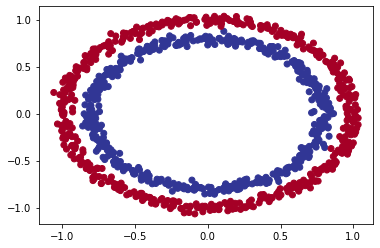

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [6]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test splits

1. Turn our data into tensors (right now our data is in NumPy arrays and PyTorch prefers to work with PyTorch tensors).
2. Split our data into training and test sets (we'll train a model on the training set to learn the patterns between `X` and `y` and then evaluate those learned patterns on the test dataset).

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing `nn.Module`.
3. Defining a loss function and optimizer.
4. Creating a training loop.

In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

![A visual example of what a classification neural network with linear activation looks like on the tensorflow playground](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-tensorflow-playground-linear-activation.png)
*A visual example of what a similar classificiation neural network to the one we've just built looks like. Try create one of your own on the [TensorFlow Playground website](https://playground.tensorflow.org/).*

You can also do the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [12]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.2836],
        [-0.1789],
        [-0.2727],
        [-0.2879],
        [ 0.1804],
        [ 0.2409],
        [ 0.1767],
        [ 0.2761],
        [-0.2919],
        [-0.1669]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer

| Loss function/Optimizer | Problem type | PyTorch Code |
| ----- | ----- | ----- |
| Stochastic Gradient Descent (SGD) optimizer | Classification, regression, many others. | [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) |
| Adam Optimizer | Classification, regression, many others. | [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) |
| Binary cross entropy loss | Binary classification | [`torch.nn.BCELossWithLogits`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) or [`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) |
| Cross entropy loss | Mutli-class classification | [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) |
| Mean absolute error (MAE) or L1 Loss | Regression | [`torch.nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html) | 
| Mean squared error (MSE) or L2 Loss | Regression | [`torch.nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) |  

*Table of various loss functions and optimizers, there are more but these some common ones you'll see.*

> **Note:** Recall a **loss function** is what measures how *wrong* your model predictions are, the higher the loss, the worse your model.
>
> Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

PyTorch has two binary cross entropy implementations:
1. [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).
2. [`torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - This is the same as above except it has a sigmoid layer ([`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)) built-in (we'll see what this means soon).

Which one should you use? 

The [documentation for `torch.nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer. 

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

Knowing this, let's create a loss function and an optimizer. 

For the optimizer we'll use `torch.optim.SGD()` to optimize the model parameters with learning rate 0.1.

> **Note:** There's a [discussion on the PyTorch forums about the use of `nn.BCELoss` vs. `nn.BCEWithLogitsLoss`](https://discuss.pytorch.org/t/bceloss-vs-bcewithlogitsloss/33586/4). It can be confusing at first but as with many things, it becomes easier with practice.

In [14]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [13]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

## 3. Train model

Okay, now we've got a loss function and optimizer ready to go, let's train a model.

Do you remember the steps in a PyTorch training loop?

If not, here's a reminder.

Steps in training:

<details>
    <summary>PyTorch training loop steps</summary>
    <ol>
        <li><b>Forward pass</b> - The model goes through all of the training data once, performing its
            <code>forward()</code> function
            calculations (<code>model(x_train)</code>).
        </li>
        <li><b>Calculate the loss</b> - The model's outputs (predictions) are compared to the ground truth and evaluated
            to see how
            wrong they are (<code>loss = loss_fn(y_pred, y_train</code>).</li>
        <li><b>Zero gradients</b> - The optimizers gradients are set to zero (they are accumulated by default) so they
            can be
            recalculated for the specific training step (<code>optimizer.zero_grad()</code>).</li>
        <li><b>Perform backpropagation on the loss</b> - Computes the gradient of the loss with respect for every model
            parameter to
            be updated (each parameter
            with <code>requires_grad=True</code>). This is known as <b>backpropagation</b>, hence "backwards"
            (<code>loss.backward()</code>).</li>
        <li><b>Step the optimizer (gradient descent)</b> - Update the parameters with <code>requires_grad=True</code>
            with respect to the loss
            gradients in order to improve them (<code>optimizer.step()</code>).</li>
    </ol>
</details>



### Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

Before we the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the `foward()` method).

To do so, let's pass the model some data.

In [17]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.2836],
        [-0.1789],
        [-0.2727],
        [-0.2879],
        [ 0.1804]], device='cuda:0', grad_fn=<SliceBackward0>)

In [18]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4296],
        [0.4554],
        [0.4322],
        [0.4285],
        [0.5450]], device='cuda:0', grad_fn=<SigmoidBackward0>)

Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

They're now in the form of **prediction probabilities** (I usually refer to these as `y_pred_probs`), in other words, the values are now how much the model thinks the data point belongs to one class or another.

In our case, since we're dealing with binary classification, our ideal outputs are 0 or 1.

So these values can be viewed as a decision boundary.

The closer to 0, the more the model thinks the sample belongs to class 0, the closer to 1, the more the model thinks the sample belongs to class 1.

More specificially:
* If `y_pred_probs` >= 0.5, `y=1` (class 1)
* If `y_pred_probs` < 0.5, `y=0` (class 0)

To turn our prediction probabilities in prediction labels, we can round the outputs of the sigmoid activation function.

In [19]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our models predictions to the test labels to see how well it's going. 

To recap, we converted our model's raw outputs (logits) to predicition probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

> **Note:** The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the [softmax activation function](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) (this will come later on).
>
> And the use of the sigmoid activation function is not required when passing our model's raw outputs to the `nn.BCEWithLogitsLoss` (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.

### Building a training and testing loop

In [21]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70102, Accuracy: 49.88% | Test loss: 0.70143, Test acc: 48.00%
Epoch: 10 | Loss: 0.69897, Accuracy: 49.88% | Test loss: 0.69964, Test acc: 50.50%
Epoch: 20 | Loss: 0.69763, Accuracy: 49.38% | Test loss: 0.69856, Test acc: 52.00%
Epoch: 30 | Loss: 0.69667, Accuracy: 49.12% | Test loss: 0.69783, Test acc: 51.50%
Epoch: 40 | Loss: 0.69595, Accuracy: 49.88% | Test loss: 0.69731, Test acc: 51.50%
Epoch: 50 | Loss: 0.69539, Accuracy: 50.00% | Test loss: 0.69692, Test acc: 52.50%
Epoch: 60 | Loss: 0.69495, Accuracy: 50.00% | Test loss: 0.69661, Test acc: 52.50%
Epoch: 70 | Loss: 0.69460, Accuracy: 49.62% | Test loss: 0.69637, Test acc: 51.50%
Epoch: 80 | Loss: 0.69431, Accuracy: 49.88% | Test loss: 0.69617, Test acc: 49.50%
Epoch: 90 | Loss: 0.69408, Accuracy: 50.50% | Test loss: 0.69600, Test acc: 50.00%


## Make predictions and evaluate the model

In [18]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


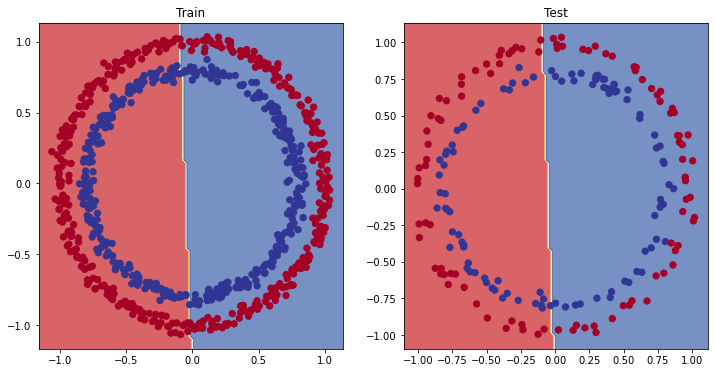

In [23]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model (from a model perspective) 

| Model improvement technique* | What does it do? |
| ----- | ----- |
| **Add more layers** | Each layer *potentially* increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network *deeper*. |
| **Add more hidden units** | Similar to the above, more hidden units per layer means a *potential* increase in learning capabilities of the model, more hidden units is often referred to as making your neural network *wider*. |
| **Fitting for longer (more epochs)** | Your model might learn more if it had more opportunities to look at the data. |
| **Changing the activation functions** | Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint). |
| **Change the learning rate** | Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough. |
| **Change the loss function** | Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem. |
| **Use transfer learning** | Take a pretrained model from a problem domain similar to yours and adjust it to your own problem. We cover transfer learning in [notebook 06](https://www.learnpytorch.io/06_pytorch_transfer_learning/). |

> **Note:** *because you can adjust all of these by hand, they're referred to as **hyperparameters**. 
>
> And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".

Let's see what happens if we add an extra layer to our model, fit for longer (`epochs=1000` instead of `epochs=100`) and increase the number of hidden units from `5` to `10`.

We'll follow the same steps we did above but with a few changed hyperparameters.

In [24]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

Beautiful, model, optimizer and loss function ready, let's make a training loop.

This time we'll train for longer (`epochs=1000` vs `epochs=100`) and see if it improves our model. 

In [26]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


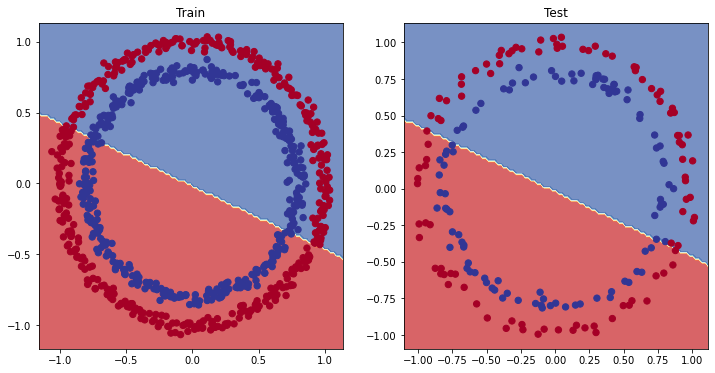

In [27]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### Building a model with non-linearity 

PyTorch has a bunch of [ready-made non-linear activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) that do similiar but different things. 

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (rectified linear-unit, [`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)).

In [28]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


![a classification neural network on TensorFlow playground with ReLU activation](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-tensorflow-playground-relu-activation.png)
*A visual example of what a similar classificiation neural network to the one we've just built (suing ReLU activation) looks like. Try create one of your own on the [TensorFlow Playground website](https://playground.tensorflow.org/).*

> **Question:** *Where should I put the non-linear activation functions when constructing a neural network?*
>
> A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantine, best to experiment, experiment, experiment.

In [29]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [30]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


### Evaluating a model trained with non-linear activation functions

In [31]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

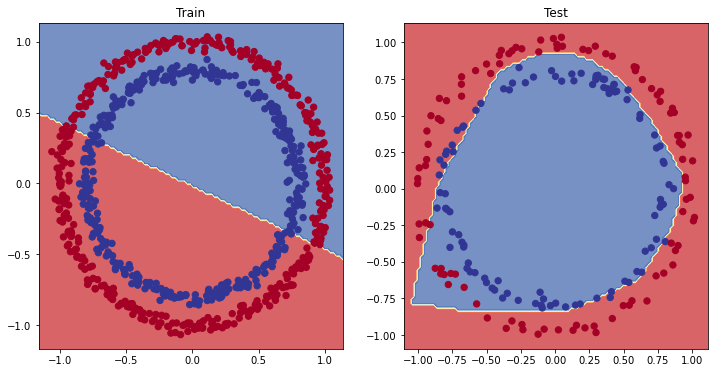

In [32]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## Putting things together by building a multi-class PyTorch model

Recall a **binary classification** problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a **multi-class classification** problem deals with classifying something from a list of *more than* two options (e.g. classifying a photo as a cat a dog or a chicken).

### Creating mutli-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's [`make_blobs()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


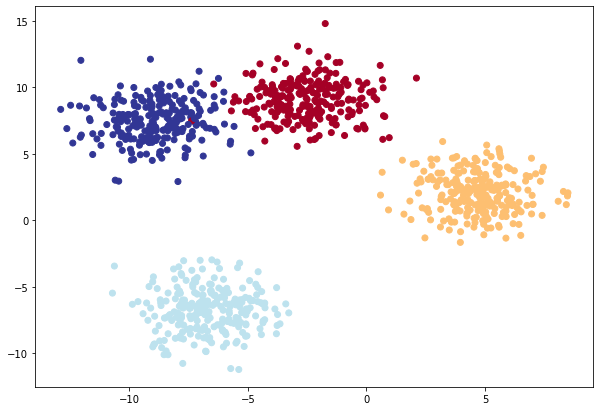

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [2]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [25]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.01)

In [26]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [27]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [28]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [29]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [30]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


In [31]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.96335, Test Acc: 71.00%
Epoch: 10 | Loss: 0.63688, Acc: 79.50% | Test Loss: 0.61222, Test Acc: 88.00%
Epoch: 20 | Loss: 0.46945, Acc: 97.75% | Test Loss: 0.45865, Test Acc: 98.00%
Epoch: 30 | Loss: 0.37339, Acc: 98.50% | Test Loss: 0.36771, Test Acc: 99.00%
Epoch: 40 | Loss: 0.31009, Acc: 98.62% | Test Loss: 0.30659, Test Acc: 99.00%
Epoch: 50 | Loss: 0.26486, Acc: 98.88% | Test Loss: 0.26227, Test Acc: 99.00%
Epoch: 60 | Loss: 0.23082, Acc: 98.88% | Test Loss: 0.22853, Test Acc: 99.50%
Epoch: 70 | Loss: 0.20429, Acc: 99.12% | Test Loss: 0.20197, Test Acc: 99.50%
Epoch: 80 | Loss: 0.18307, Acc: 99.12% | Test Loss: 0.18057, Test Acc: 99.00%
Epoch: 90 | Loss: 0.16578, Acc: 99.12% | Test Loss: 0.16301, Test Acc: 99.00%


In [34]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
print(y_logits[:10])
print(y_logits[:10].to('cpu').shape)
print(y_logits[:10].to('cpu').ndim)

tensor([[ 0.6728,  2.8048, -5.8948, -3.6846],
        [ 3.1247, -4.3091,  1.2266,  4.8820],
        [-0.3193, -3.6616,  8.5252,  4.9316],
        [ 0.1084,  2.1751, -3.3363, -2.7251],
        [ 2.6332,  0.2090, -5.9259, -0.8331],
        [ 3.6064, -5.2834,  1.8419,  6.0177],
        [-0.7624, -2.6307,  7.7098,  3.7128],
        [ 2.6994, -0.9662, -3.9135,  0.6692],
        [ 0.2015, -5.3148, 10.3011,  6.9350],
        [ 2.6329, -0.5243, -4.5675,  0.1151]], device='cuda:0')
torch.Size([10, 4])
2


In [16]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.0%


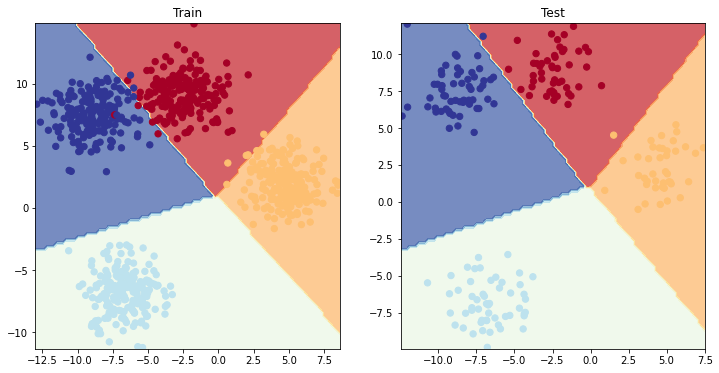

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## More classification evaluation metrics

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate you classification model using more metrics such as the following:

| **Metric name/Evaluation method** | **Defintion** | **Code** |
| --- | --- | --- |
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | [`torchmetrics.Accuracy()`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#id3) or [`sklearn.metrics.accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | [`torchmetrics.Precision()`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#id4) or [`sklearn.metrics.precision_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | [`torchmetrics.Recall()`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#id5) or [`sklearn.metrics.recall_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | [`torchmetrics.F1Score()`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#f1score) or [`sklearn.metrics.f1_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) |
| [Confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)  | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#confusionmatrix) or [`sklearn.metrics.plot_confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay.from_predictions) |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | [`sklearn.metrics.classification_report()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/), especially the [TorchMetrics classification section](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#classification). 

Let's try the `torchmetrics.Accuracy` metric out.




In [35]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9900, device='cuda:0')